# COVID-19 Situation by country

In [1]:
#今
!date

2020年  4月  1日 水曜日 10:07:26 JST


In [2]:
import os
import sys
from pathlib import Path
from datetime import datetime,timezone,timedelta
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
np.set_printoptions(linewidth=120)
%matplotlib inline
#%matplotlib notebook  # If you switch from inline to notebook, you must restart the kernel!

# Utility 

In [3]:
# 増加分columns名suffix
suffixinc = 'increase_'
sufficma = 'MA?_'
reqcol_cases =  ['Confirmed', 'Deaths', 'Recovered'] 


#地域毎に日単位集計
def get_daily_by(df, cname=None, sname=None):
    reqcol = [ vn  for vn in reqcol_cases if vn in df.columns]
    grplist = []
    qrystr = ''
    if(cname is not None):
        grplist.append('Country')
        qrystr += f'Country == "{cname}"'
    if(sname is not None):
        grplist.append('State')
        qrystr += f'{" " if len(qrystr) == 0 else " and "}State == "{sname}"'
    grplist.append('Date')
    df_grouped = df.groupby( grplist, as_index=False)[reqcol].sum()
    ret = df_grouped.query(qrystr)
    ret.index = ret['Date'] 
    ret = ret[reqcol]
    return(ret)

# 移動平均を出す処理
def get_moving_average(df, days):
    ret = df.rolling(days).mean().fillna(0)
    suf = sufficma.replace('?', f'{days}')
    ret.columns = [ suf+cname for cname in df.columns ]
    return(ret)

# 増加分を出す処理
def get_increase(df):
    df = df.copy()
    dfinc = df.diff().fillna(0)
    dfinc.columns =  [ suffixinc+cname for cname in df.columns ]
    return(dfinc)

# 補正案の処理
def get_correct_by_increase(df):
    df = df.copy()
    dfinc = get_increase(df)   
    for col in df.columns:
        df[col] = df[col] + np.append(np.minimum(dfinc[suffixinc+col], 0).values[1:], 0)
    return(df)

# 国毎にtotalと増加を生成する
def get_total_and_increase( df, cname ):
    tmp = get_daily_by(df, cname)
    return( pd.concat([tmp, get_increase(tmp)], axis=1))

# 国毎にtotalから派生データを作る
def get_derived( df, inc=True, ma=True, madays=3):
    tmp = pd.concat([df, get_increase(df)], axis=1)
    tmp = pd.concat([tmp, get_moving_average(tmp, madays) ], axis=1)
    return(tmp)


# 国毎の最新情報を生成する
def get_latest_by_country( df ):
    cnames = df['Country'].unique()
    reqcol = [ vn  for vn in reqcol_cases if vn in df.columns]
    df_grouped = df.groupby(['Country', 'Date'], as_index=False)[reqcol].sum()
    clasts = []
    for cname in cnames:
        tmp = df_grouped.query(f'Country ==  "{cname}"').iloc[-1:,:]
        tmp['Country'] = cname
        clasts.append(tmp)
    return(pd.concat(clasts, axis=0))

# プロットする
def displot( df, ax, title='', figsize=None, kind='normal'):
    if( type(kind) == str):
        if(kind == 'normal'):
            kind = {'lines':['Confirmed', 'Deaths', 'Recovered','MA3_increase_Confirmed'], 'bars':['increase_Confirmed'] }
        if(kind == 'incbase'):
            kind = {'lines':['MA3_increase_Confirmed'], 'bars':['increase_Confirmed'] }
    assert type(kind) == dict, f'kind error! {kind}'
    lines = [ vn  for vn in kind['lines'] if vn in df.columns]
    bars = [ vn  for vn in kind['bars']if vn in df.columns]
    
    if(ax is None):
        fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    #ax2=ax.twinx()
    ax2 = ax
    
    for one in bars:
        ax2.bar(df.index, df[one], label=one)

    for one in lines:
        ex = ax
        if( suffixinc in one):
            ex = ax2
        ex.plot(df.index, df[one], label=one)
    
    if(title is not None):
        title += f' (at {df.index[-1].to_pydatetime().strftime("%Y/%m/%d")})'
        title += '\n (latest'
        for one in lines:
            title += f' / {df[one].values[-1]:.1f}'
        title += ')'
        if(len(bars) > 0):
            title += f'\n (inc {df[bars[0]].values[-4:]})'
        ax.set_title(title)
    ax.legend()
    #ax2.set_ylim( (ax2.get_ylim()[0]*2,  ax2.get_ylim()[1]*2))
    #ax2.legend(loc='center left')
    #plt.show()

<hr>

# データ・セット読み込み

### <u>Johns Hopkins University has made an excellent dashboard</u>  
Johns Hopkins Github repository  
https://github.com/CSSEGISandData/COVID-19

### pullする

In [4]:
!git -C ../../COVID-19  pull

Already up to date.


In [5]:
# 表示
!git -C ../../COVID-19  log -n 3 --name-status
#!ls -l ../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/

commit 42ded9fd324391e65dfdf56fbfb2aff45a2514a6 (HEAD -> master, origin/master, origin/HEAD)
Author: Ryan Lau <ryan.lau@jhuapl.edu>
Date:   Tue Mar 31 20:08:36 2020 -0400

    update 03-31-2020 daily report

A	csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv

commit 9951068de409f7a39d4e4cf7498eff15d33fd032
Author: CSSEGISandData <jhusystems@gmail.com>
Date:   Tue Mar 31 23:55:36 2020 +0000

    automated update

M	csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
M	csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
M	csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

commit 376119aa4b3dbc37b863ac11d4984e480e81227b
Author: CSSEGISandData <60674295+CSSEGISandData@users.noreply.github.com>
Date:   Tue Mar 31 14:05:46 2020 -0400

    add 3/22 and 3/30

M	csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
M	csse_covid_19_data/csse_covid_19_time_

### TimeSeriesデータを読み込む   

In [6]:
# csse生のデータ読み込み
#csse_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'  #githubから直接
csse_url='../../COVID-19/'
csse_raw = {}
csse_raw['Confirmed'] = pd.read_csv(f'{csse_url}csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
csse_raw['Deaths']    = pd.read_csv(f'{csse_url}csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
csse_raw['Recovered'] = pd.read_csv(f'{csse_url}csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
for _, val in csse_raw.items():
    val.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)


In [7]:
# 生データは、case(confimed/deaths/)に分かれているので合体させる。
def csse_concat(dfdict):
    melted = {}
    for key, val in dfdict.items():
        melted[key] = val.melt(id_vars=['State', 'Country', 'Lat', 'Long']
                                                 ,  value_vars=val.columns[4:], var_name='Date', value_name=key)
        melted[key]['Date'] = pd.to_datetime(melted[key]['Date'] )
        melted[key]['State'] = melted[key]['State'].fillna('')
        melted[key] = melted[key].fillna(0)
    
    merged = None
    for  key, val in melted.items():
        if(merged is None):
            merged = val
            continue
        merged = pd.merge(merged, val, on=['State', 'Country', 'Lat', 'Long', 'Date'],  how='outer')
    retdf = merged
    for key in dfdict.keys():
            retdf[key] = retdf[key].fillna(0)
    return(retdf)

# 合体したdf
csse_df = csse_concat(csse_raw)

# プリプロセス

In [8]:
use_df = csse_df

#### 国毎に集計テーブルを生成

In [9]:
country_dfs = {}
for  cname in use_df['Country'].unique():
    tmp = get_daily_by(use_df, cname)
    tmp = get_derived(tmp)
    country_dfs[cname] =  tmp

#### 各国直近テーブルを生成

In [10]:
country_latest = pd.concat( [ val[-1:] for val in country_dfs.values()], axis=0, sort=False )
country_latest.index = country_dfs.keys()

* <u>感染者数の多い順</u>

In [11]:
country_latest.sort_values(by='Confirmed', ascending=False).head()

,Confirmed,Deaths,Recovered,increase_Confirmed,increase_Deaths,increase_Recovered,MA3_Confirmed,MA3_Deaths,MA3_Recovered,MA3_increase_Confirmed,MA3_increase_Deaths,MA3_increase_Recovered
US,188172.0,3873.0,7024.0,26365.0,895.0,1380.0,163621.666667,3106.000000,5111.000000,22231.333333,615.666667,1984.000000
Italy,105792.0,12428.0,15729.0,4053.0,837.0,1109.0,101740.000000,11599.333333,14459.666667,4440.000000,801.666667,1115.000000
Spain,95923.0,8464.0,19259.0,7967.0,748.0,2479.0,87996.333333,7661.000000,16916.000000,7562.666667,827.333333,2324.666667
China,82279.0,3309.0,76206.0,81.0,1.0,283.0,82199.666667,3307.000000,75903.666667,93.333333,3.333333,368.666667
Germany,71808.0,775.0,16100.0,4923.0,130.0,2600.0,66929.333333,651.000000,12937.000000,4704.333333,114.000000,2539.666667


* <u>直近３日の感染者増加数が多い順</u>

In [12]:
country_latest.sort_values(by='MA3_increase_Confirmed', ascending=False).head(14)

,Confirmed,Deaths,Recovered,increase_Confirmed,increase_Deaths,increase_Recovered,MA3_Confirmed,MA3_Deaths,MA3_Recovered,MA3_increase_Confirmed,MA3_increase_Deaths,MA3_increase_Recovered
US,188172.0,3873.0,7024.0,26365.0,895.0,1380.0,163621.666667,3106.000000,5111.000000,22231.333333,615.666667,1984.000000
Spain,95923.0,8464.0,19259.0,7967.0,748.0,2479.0,87996.333333,7661.000000,16916.000000,7562.666667,827.333333,2324.666667
France,52827.0,3532.0,9513.0,7657.0,502.0,1549.0,46235.000000,3057.666667,8234.333333,4907.333333,405.000000,1263.000000
Germany,71808.0,775.0,16100.0,4923.0,130.0,2600.0,66929.333333,651.000000,12937.000000,4704.333333,114.000000,2539.666667
Italy,105792.0,12428.0,15729.0,4053.0,837.0,1109.0,101740.000000,11599.333333,14459.666667,4440.000000,801.666667,1115.000000
Iran,44605.0,2898.0,14656.0,3110.0,141.0,745.0,41469.666667,2765.000000,13652.666667,3065.666667,127.000000,992.333333
United Kingdom,25481.0,1793.0,179.0,3028.0,382.0,8.0,22571.333333,1478.333333,167.000000,2723.000000,257.333333,9.333333
Turkey,13531.0,214.0,243.0,2704.0,46.0,81.0,11191.666667,171.000000,170.000000,2043.000000,35.333333,57.666667
Belgium,12775.0,705.0,1696.0,876.0,192.0,169.0,11836.666667,549.666667,1527.333333,1213.666667,117.333333,211.000000
Canada,8527.0,101.0,1592.0,1129.0,21.0,1126.0,7401.666667,81.666667,841.333333,983.666667,13.333333,375.333333


# 表示

### 日本　（人口1.268億）  ※最近データの更新が遅れたり誤ったりしているので注意

In [13]:
country_dfs['Japan'].tail(14)

,Confirmed,Deaths,Recovered,increase_Confirmed,increase_Deaths,increase_Recovered,MA3_Confirmed,MA3_Deaths,MA3_Recovered,MA3_increase_Confirmed,MA3_increase_Deaths,MA3_increase_Recovered
Date,,,,,,,,,,,,
2020-03-18,889.0,29.0,144.0,11.0,0.0,0.0,868.666667,28.333333,144.000000,16.666667,2.333333,8.666667
2020-03-19,924.0,29.0,150.0,35.0,0.0,6.0,897.000000,29.000000,146.000000,28.333333,0.666667,2.000000
2020-03-20,963.0,33.0,191.0,39.0,4.0,41.0,925.333333,30.333333,161.666667,28.333333,1.333333,15.666667
2020-03-21,1007.0,35.0,232.0,44.0,2.0,41.0,964.666667,32.333333,191.000000,39.333333,2.000000,29.333333
2020-03-22,1101.0,41.0,235.0,94.0,6.0,3.0,1023.666667,36.333333,219.333333,59.000000,4.000000,28.333333
2020-03-23,1128.0,42.0,235.0,27.0,1.0,0.0,1078.666667,39.333333,234.000000,55.000000,3.000000,14.666667
2020-03-24,1193.0,43.0,285.0,65.0,1.0,50.0,1140.666667,42.000000,251.666667,62.000000,2.666667,17.666667
2020-03-25,1307.0,45.0,310.0,114.0,2.0,25.0,1209.333333,43.333333,276.666667,68.666667,1.333333,25.000000
2020-03-26,1387.0,47.0,359.0,80.0,2.0,49.0,1295.666667,45.000000,318.000000,86.333333,1.666667,41.333333


/home/ma/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


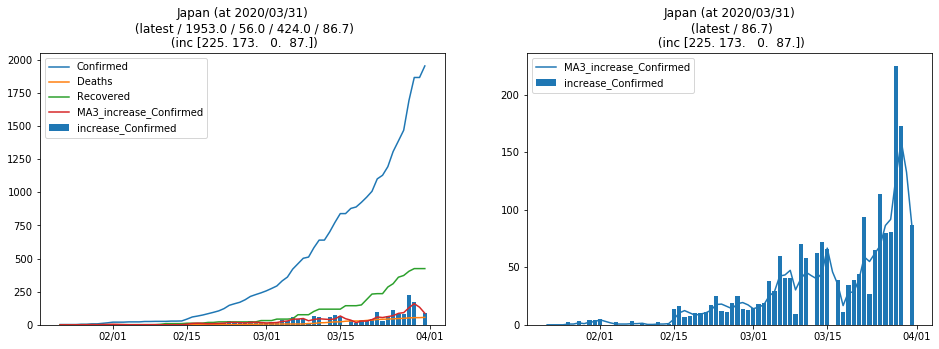

In [14]:
figsize=(16,5)
fig, axes = plt.subplots(1,2, figsize=figsize)
displot(country_dfs['Japan'], axes[0], 'Japan')
displot(country_dfs['Japan'], axes[1], 'Japan', kind='incbase')

### アメリカ　（人口3.272億）

In [15]:
country_dfs['US'].tail(10)

,Confirmed,Deaths,Recovered,increase_Confirmed,increase_Deaths,increase_Recovered,MA3_Confirmed,MA3_Deaths,MA3_Recovered,MA3_increase_Confirmed,MA3_increase_Deaths,MA3_increase_Recovered
Date,,,,,,,,,,,,
2020-03-22,33276.0,417.0,178.0,7787.0,110.0,2.0,25955.000000,322.666667,167.000000,6533.000000,72.333333,19.000000
2020-03-23,43847.0,557.0,178.0,10571.0,140.0,0.0,34204.000000,427.000000,177.333333,8249.000000,104.333333,10.333333
2020-03-24,53740.0,706.0,348.0,9893.0,149.0,170.0,43621.000000,560.000000,234.666667,9417.000000,133.000000,57.333333
2020-03-25,65778.0,942.0,361.0,12038.0,236.0,13.0,54455.000000,735.000000,295.666667,10834.000000,175.000000,61.000000
2020-03-26,83836.0,1209.0,681.0,18058.0,267.0,320.0,67784.666667,952.333333,463.333333,13329.666667,217.333333,167.666667
2020-03-27,101657.0,1581.0,869.0,17821.0,372.0,188.0,83757.000000,1244.000000,637.000000,15972.333333,291.666667,173.666667
2020-03-28,121478.0,2026.0,1072.0,19821.0,445.0,203.0,102323.666667,1605.333333,874.000000,18566.666667,361.333333,237.000000
2020-03-29,140886.0,2467.0,2665.0,19408.0,441.0,1593.0,121340.333333,2024.666667,1535.333333,19016.666667,419.333333,661.333333
2020-03-30,161807.0,2978.0,5644.0,20921.0,511.0,2979.0,141390.333333,2490.333333,3127.000000,20050.000000,465.666667,1591.666667


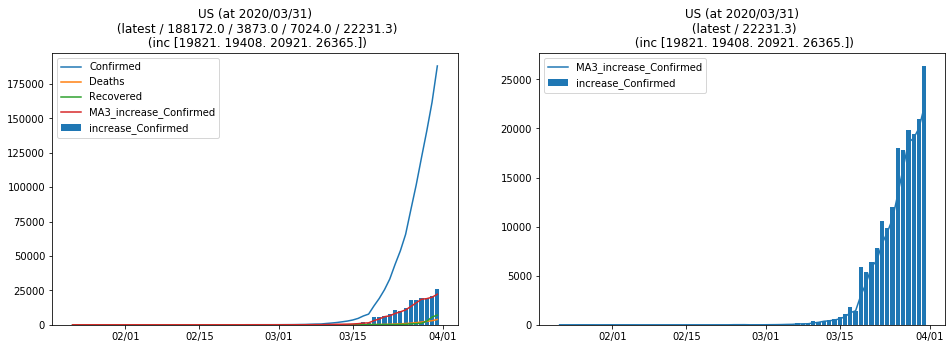

In [16]:
fig, axes = plt.subplots(1,2, figsize=figsize)
displot(country_dfs['US'], axes[0], 'US', )
displot(country_dfs['US'], axes[1], 'US',  kind='incbase')

### 韓国　（人口5100万）※先行事例１：フェーズが１番進んでそう（中国は除いて）

In [17]:
#country_dfs['Korea, South'].tail()

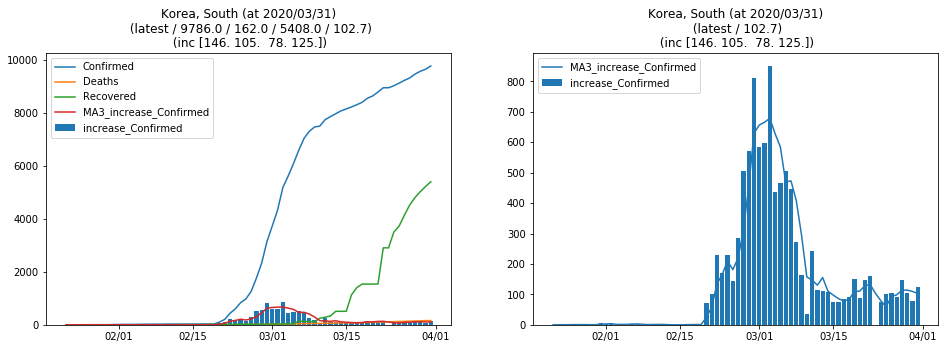

In [18]:
fig, axes = plt.subplots(1,2, figsize=figsize)
displot(country_dfs['Korea, South'], axes[0], 'Korea, South', figsize=(16,9))
displot(country_dfs['Korea, South'], axes[1], 'Korea, South', figsize=(16,9), kind='incbase')

### イタリア  (人口6048万) 　 ※先行事例２

In [19]:
#country_dfs['Italy'].tail()

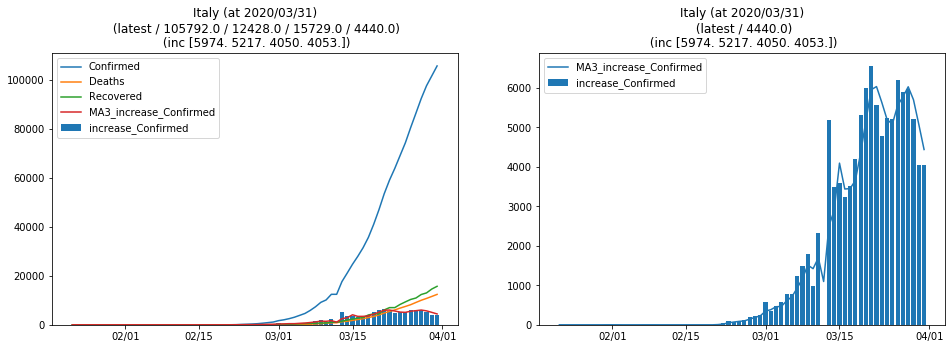

In [20]:
fig, axes = plt.subplots(1,2, figsize=figsize)
displot(country_dfs['Italy'], axes[0], 'Italy' )
displot(country_dfs['Italy'], axes[1], 'Italy', kind='incbase')

# 感染者の推移

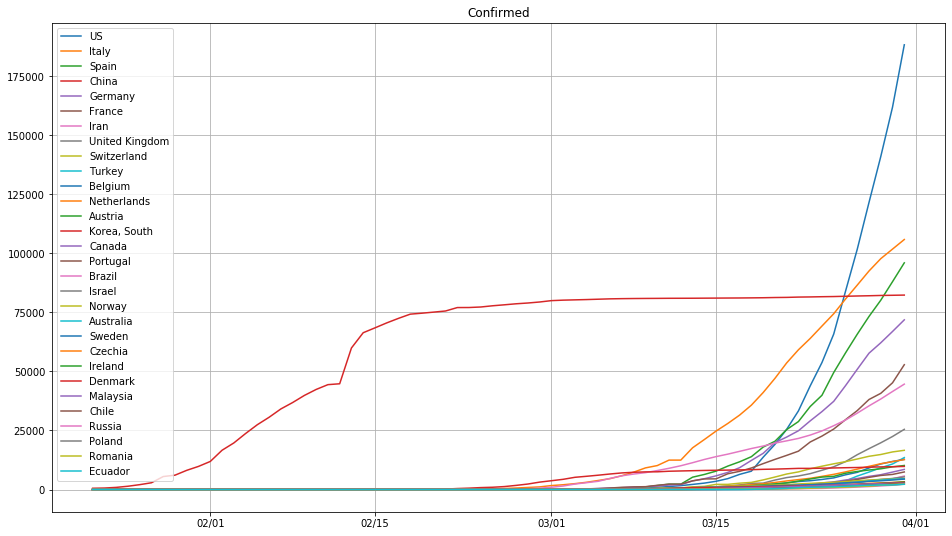

In [21]:
fig, axes = plt.subplots(1,1, figsize=(16,9))
axes.xaxis.set_major_formatter(DateFormatter('%m/%d'))
for cname in country_latest.sort_values(by='Confirmed', ascending=False).index.values[:30]:
    df = country_dfs[cname]
    axes.plot(df.index, df['Confirmed'], label=cname)
axes.set_title('Confirmed')
axes.grid(b=None, which='major', axis='both')
axes.legend()

# 世界各国（増加傾向トップ６０）

/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


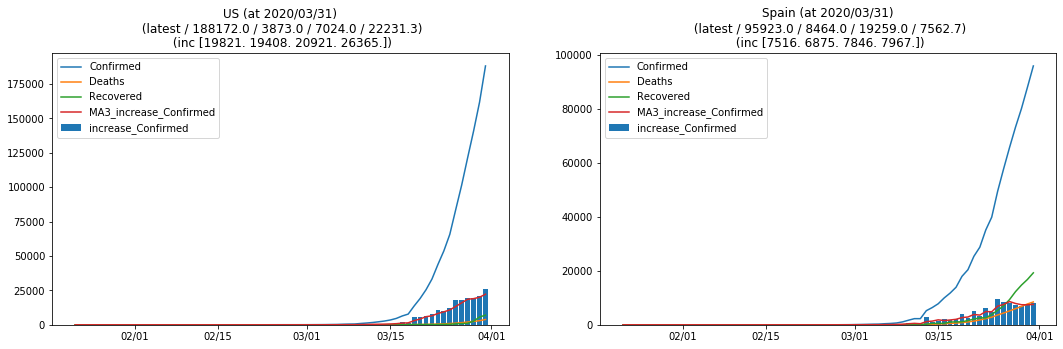

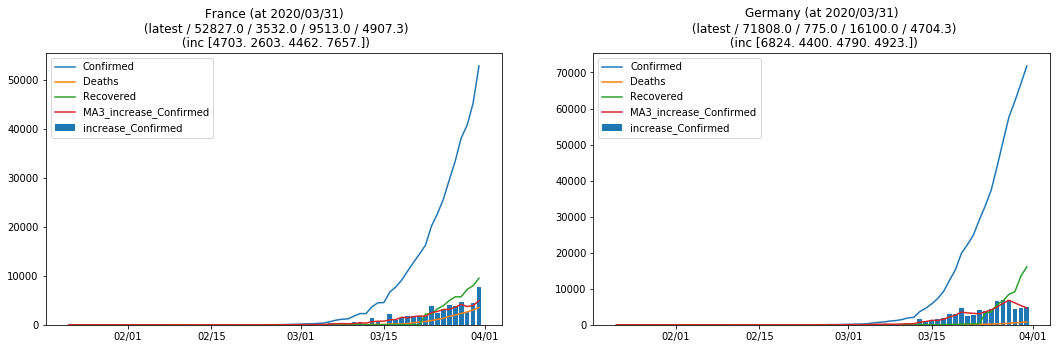

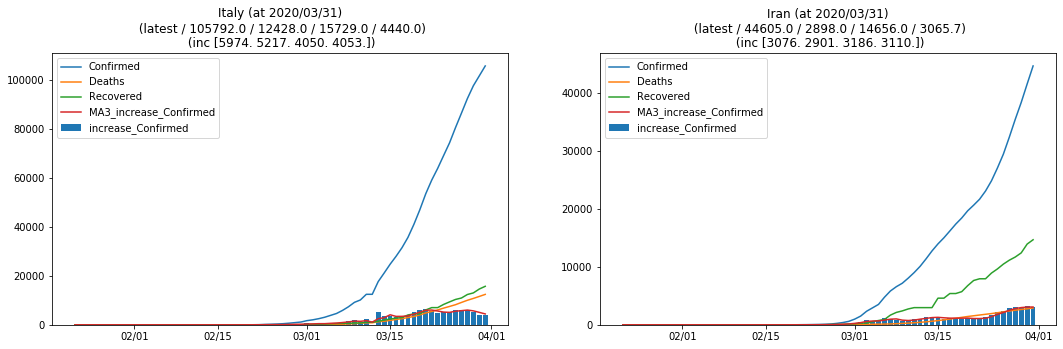

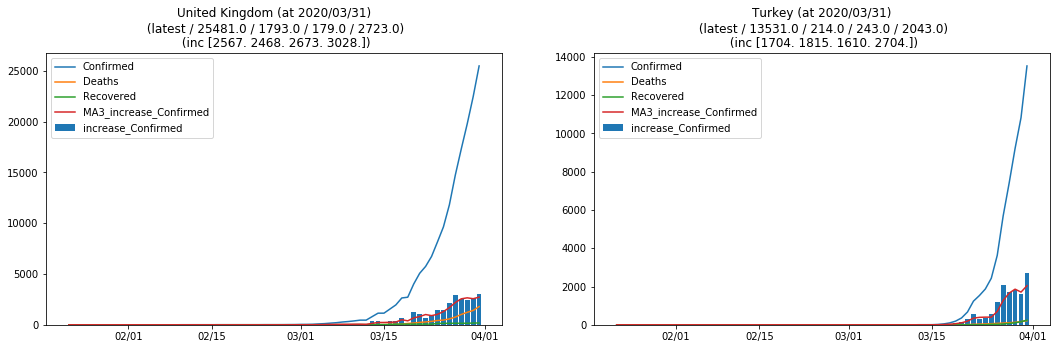

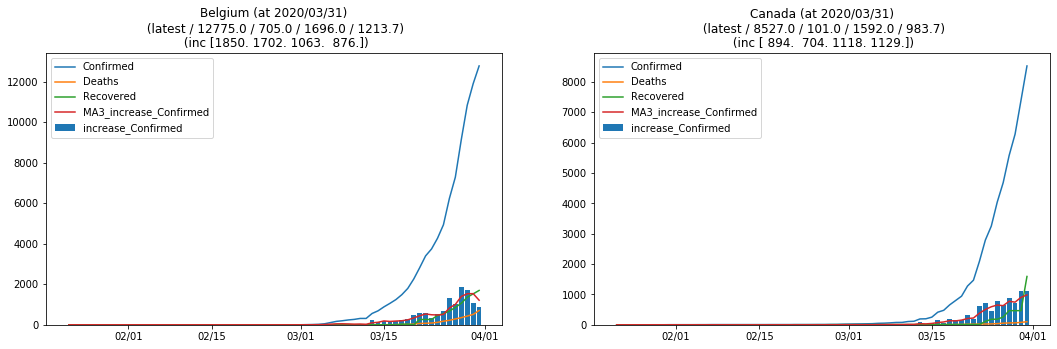

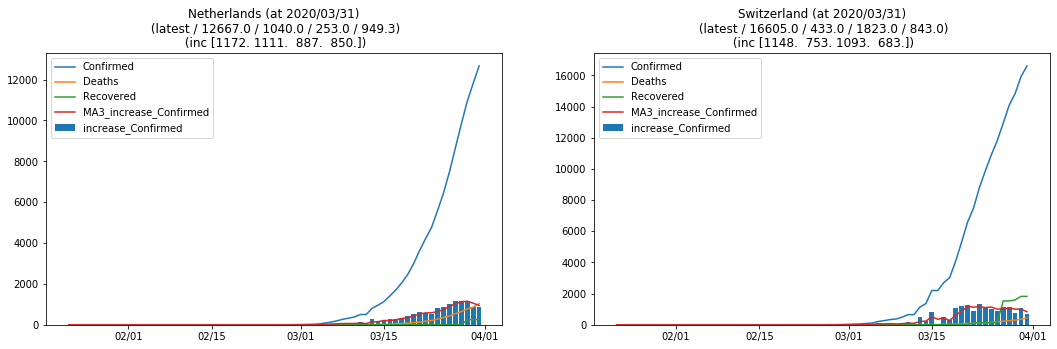

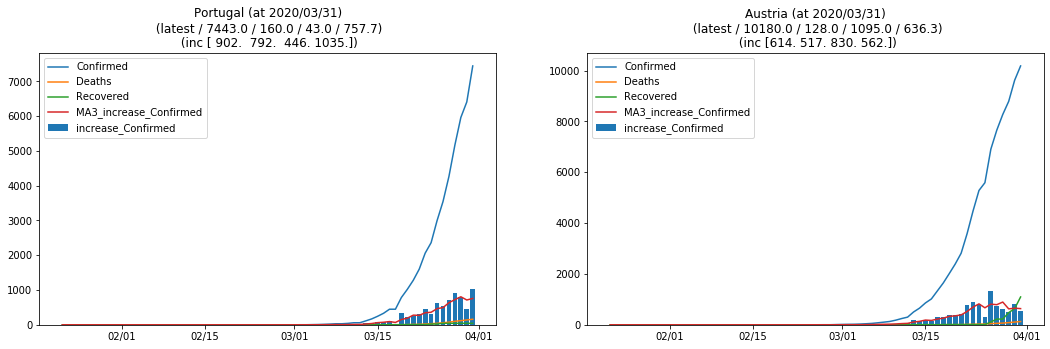

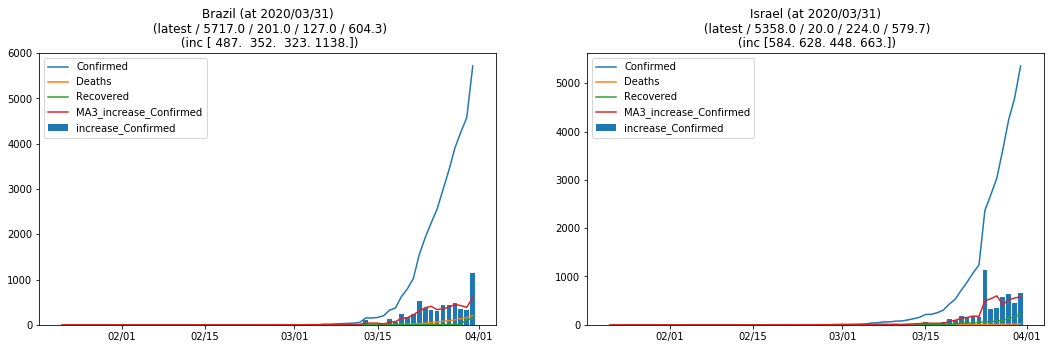

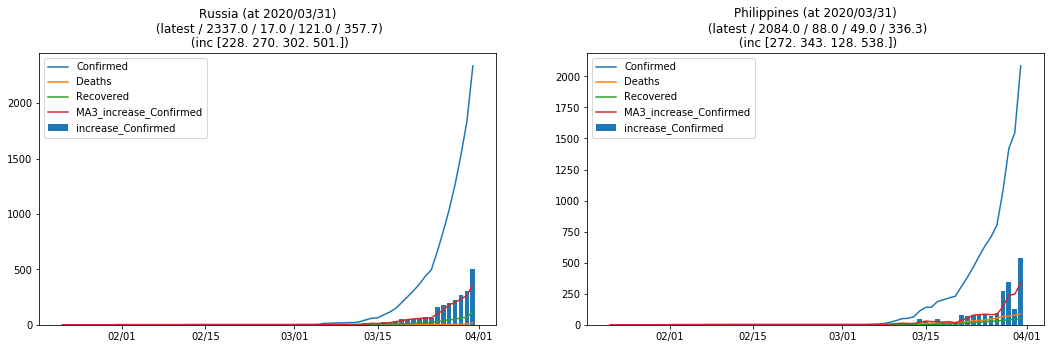

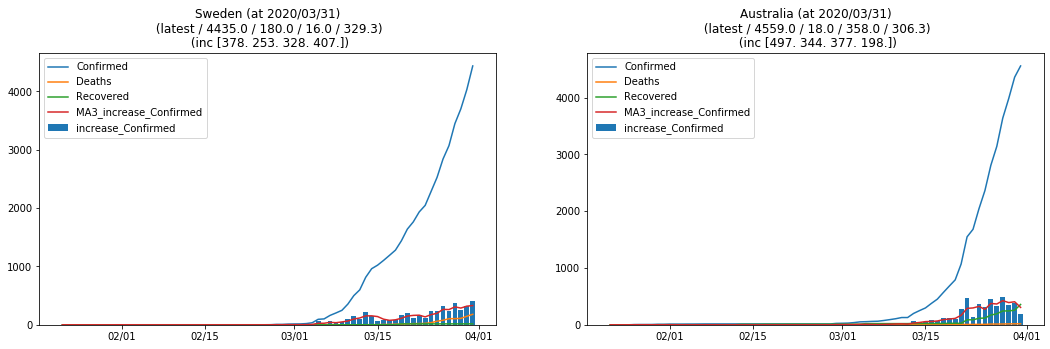

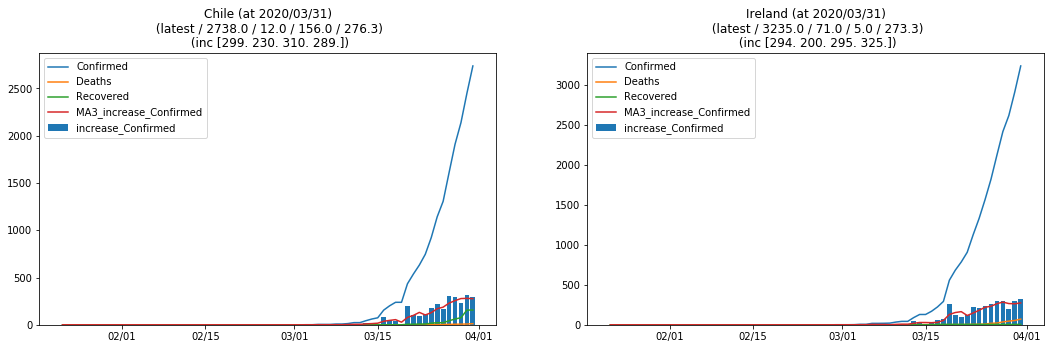

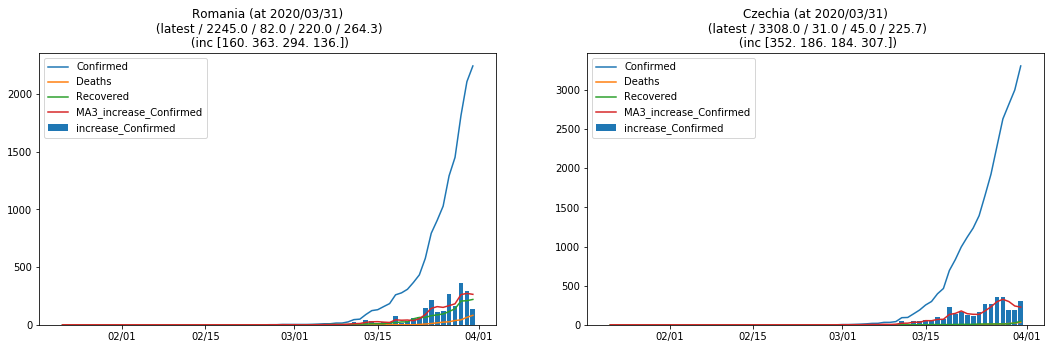

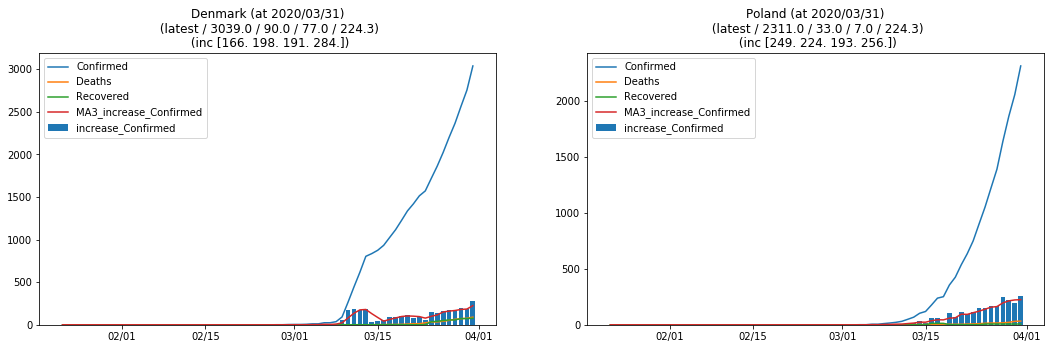

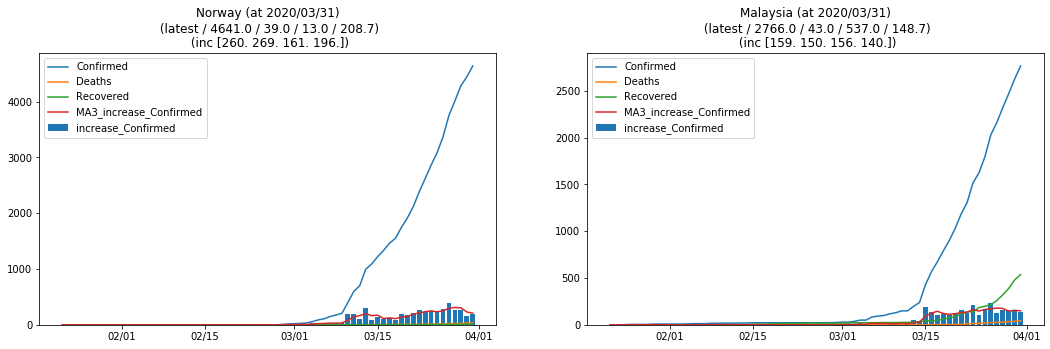

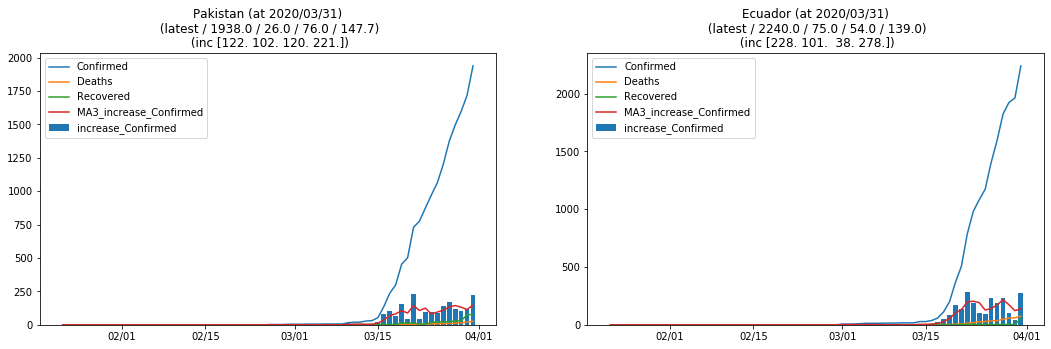

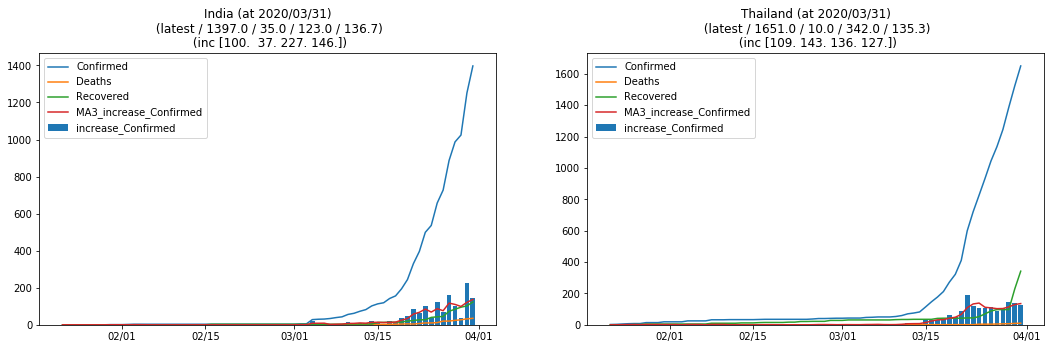

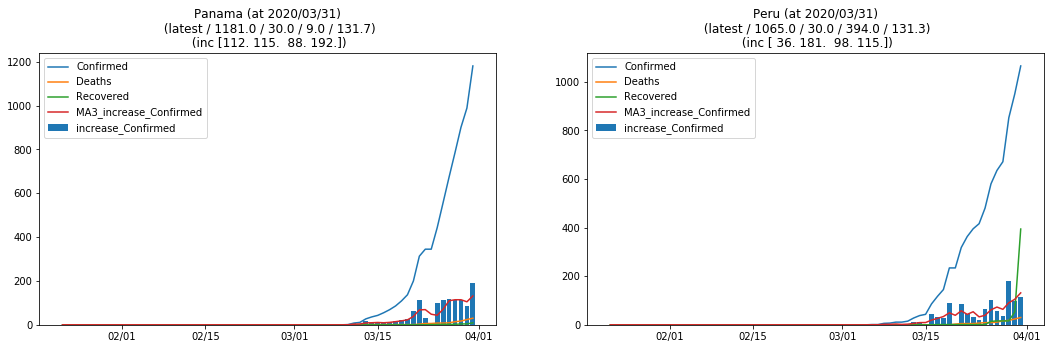

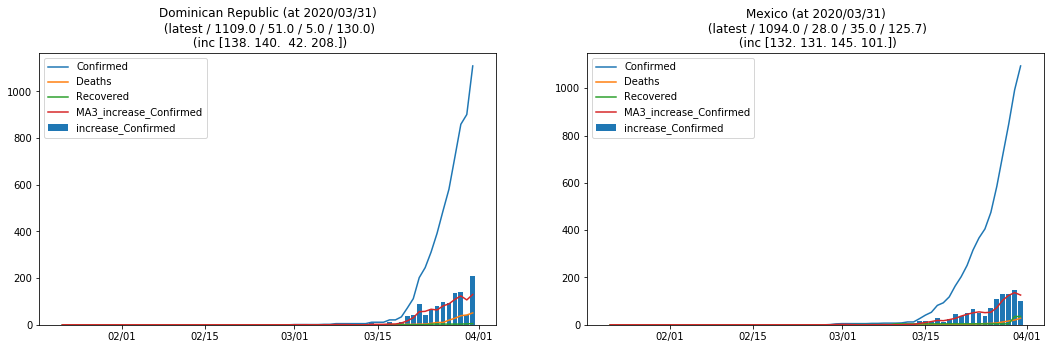

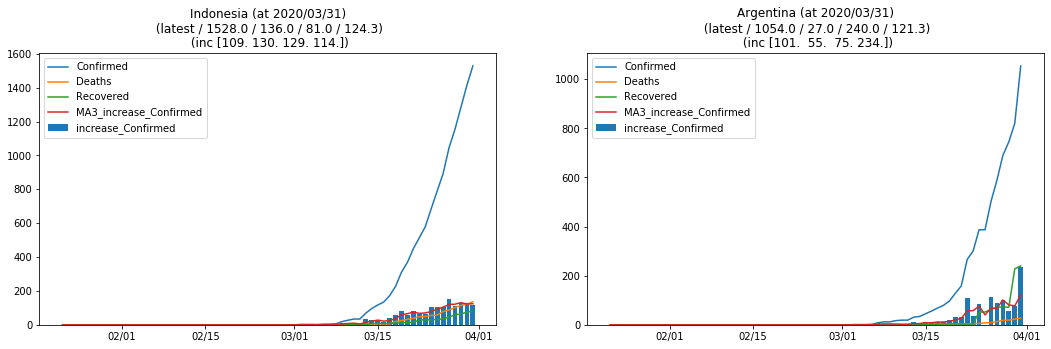

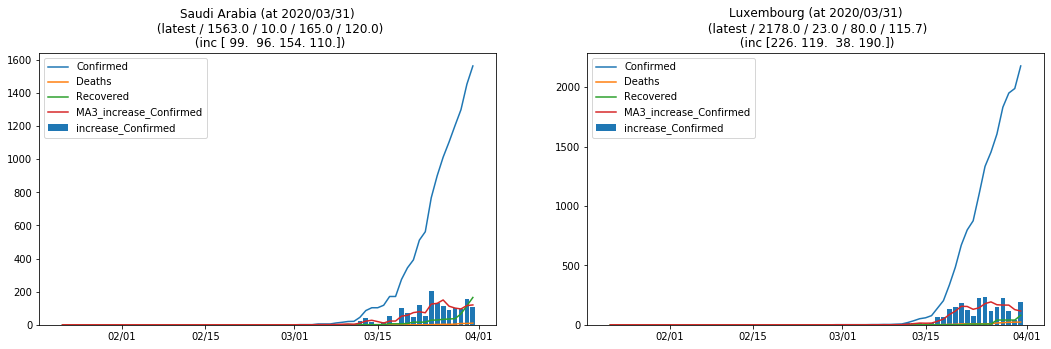

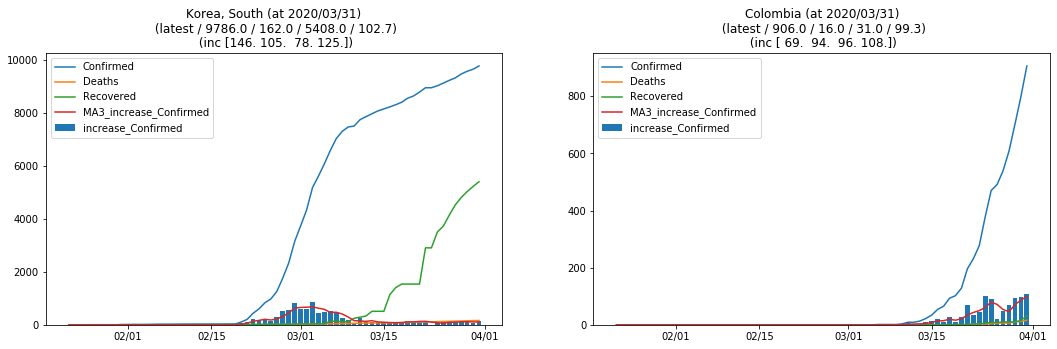

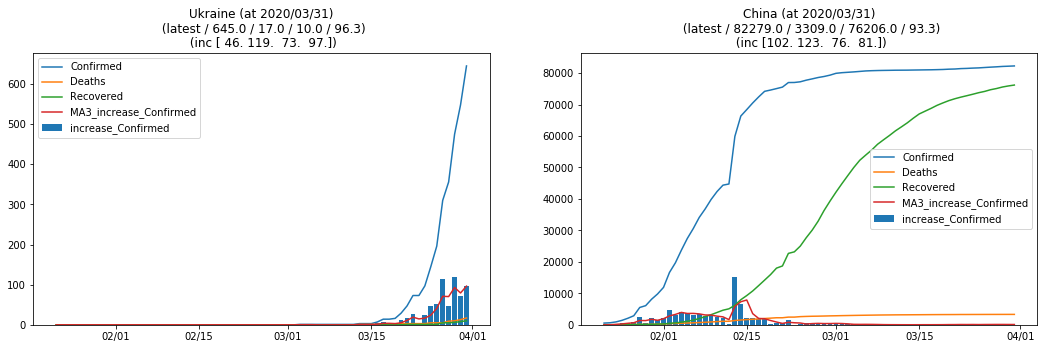

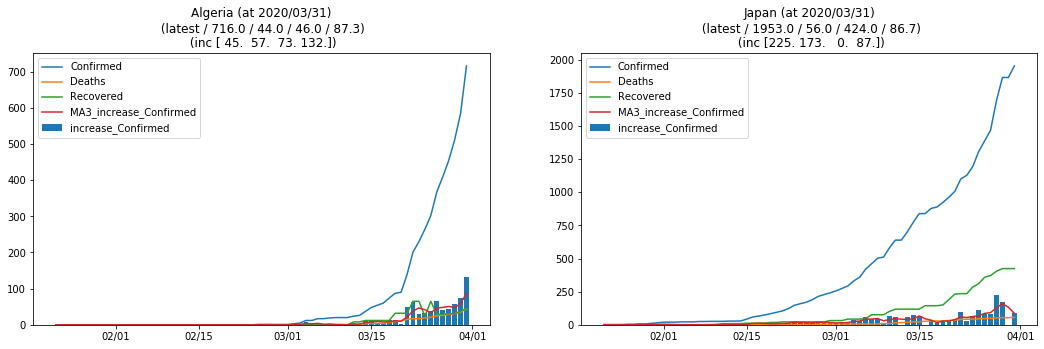

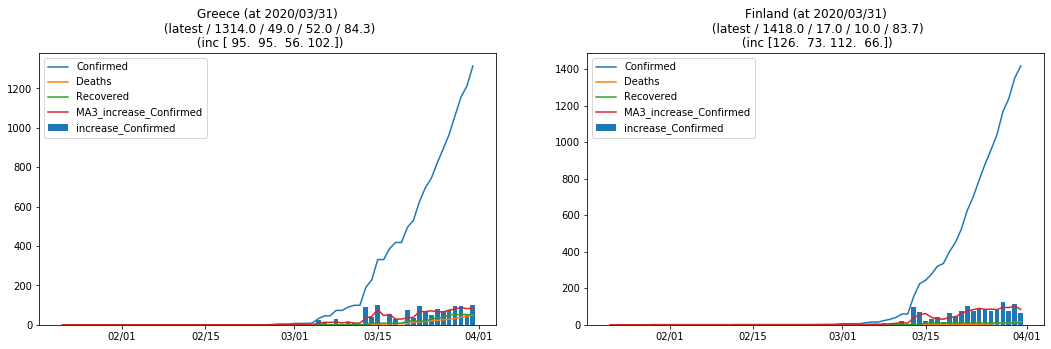

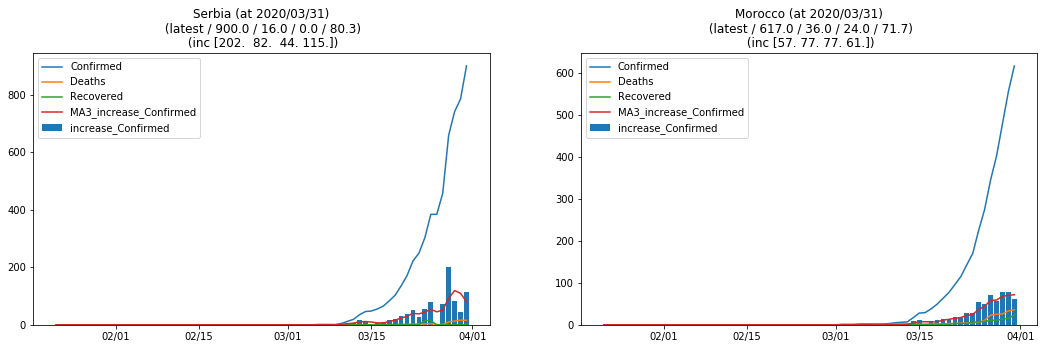

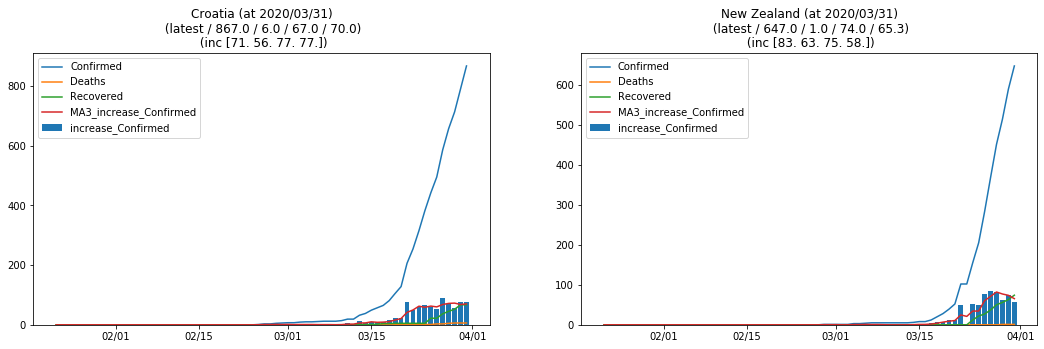

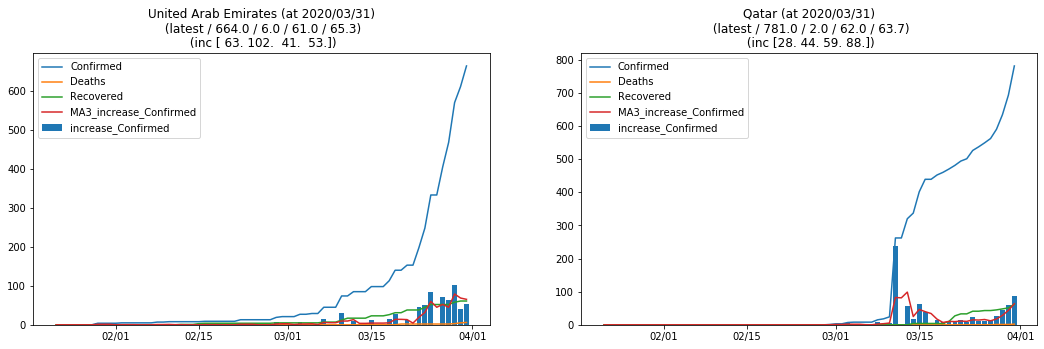

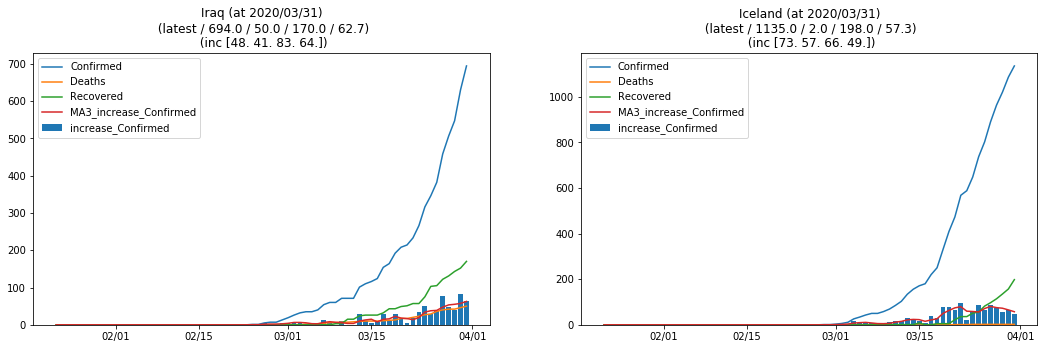

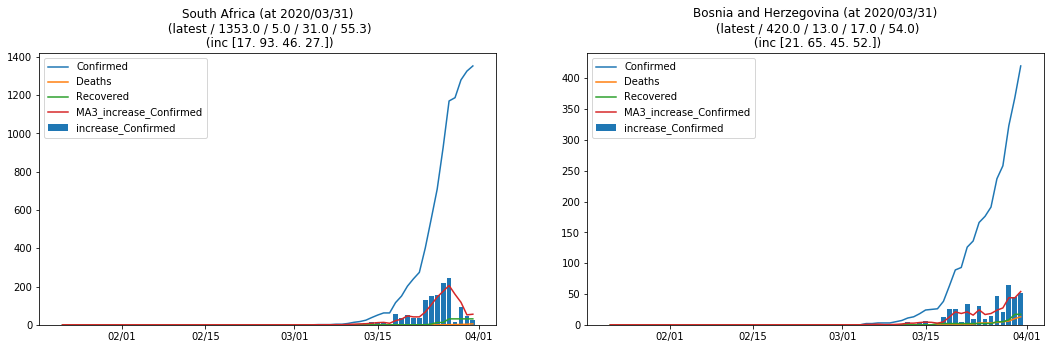

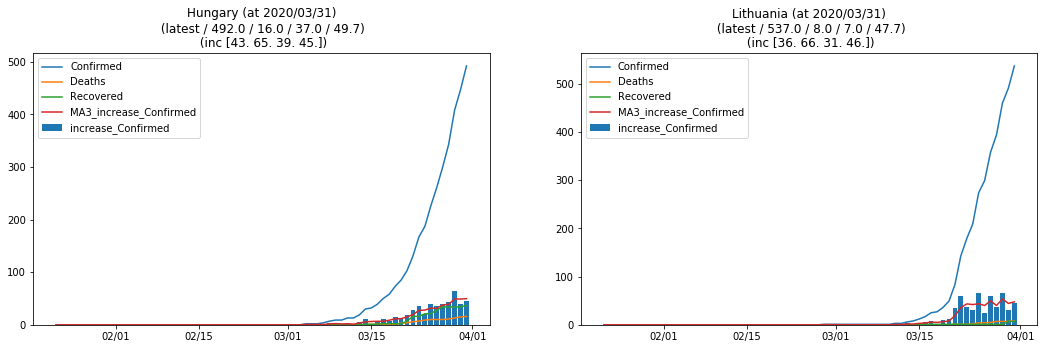

In [22]:
conum=2
ronum= 30
#ronum= (len(country_latest) + 1) // conum
cnames = country_latest.sort_values(by='MA3_increase_Confirmed', ascending=False).index.values

for i,cname in enumerate(cnames[:conum*ronum]):
    ro = i//conum
    co = i%conum
    if(co==0):
        fig, axes = plt.subplots(1,conum, figsize=(18,5))
    displot( country_dfs[cname], axes[co], cname)

ー以上ー